# Stationary GMRF simulation with Discrete Fourier Transformation

In [3]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
sys.path.append('..')
#sys.path.append('../../spystats')
import django
django.setup()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
## Use the ggplot style
plt.style.use('ggplot')

from external_plugins.spystats.spystats import tools as sptools
import scipy

## Algorithm to simulate GMRF with block-circulant Matrix.
Taken from: Rue, H., & Held, L. (2005). Gaussian Markov random fields: theory and applications. CRC press.

Algorithm 2.10

### Now let's build the circulant matrix for the tourus

Oke, for the moment I´ll follow the example in GMRF book.
i.e. a Torus (stationary of 128x128)

In [8]:
#c_delta = lambda d : np.hstack(((4 + d),-1,np.zeros(128 - 3),-1))
#c_delta = lambda d : np.hstack(((0),-1,np.zeros(128 - 3),-1))
#C = scipy.linalg.circulant(c_delta(0.1))

In [40]:
def createToroidalCircularBase(d=0.1,N=128):
    """
    Creates a circular base similar to the one described in GMRF Rue and Held, 2005.
    """
    c00 = np.hstack(((4 + d),-1,np.zeros(N - 3),-1))
    c01 = np.hstack((-1,np.zeros(N - 1)))
    c0 = np.zeros((N - 2 ,N))
    c1 = np.vstack((c00,c01))
    c = np.vstack((c1,c0))
    c[N -1, 0] = -1
    return c

CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 125 ms


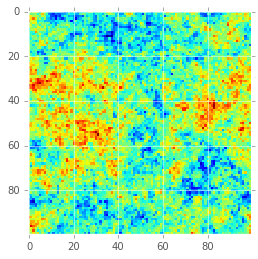

In [70]:
%%time 
## Create circular base
d = 0.00001
N = 100
c = createToroidalCircularBase(d=d,N=N)
## Simulate random noise (Normal distributed)
from scipy.fftpack import ifft2, fft2
zr = scipy.stats.norm.rvs(size=(c.size,2),loc=0,scale=1,random_state=1234)
zr.dtype=np.complex_
#plt.hist(zr.real)
#Lm = scipy.sqrt(C.shape[0]*C.shape[0]) * fft2(C)

Lm = fft2(c)
v = 1.0/ len(c) * fft2((Lm ** -0.5)* zr.reshape(Lm.shape))
x = v.real
plt.imshow(x,interpolation='None')

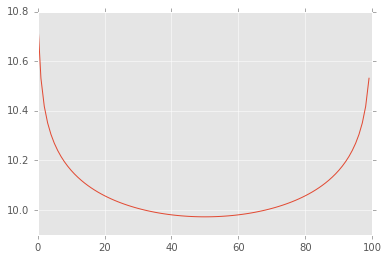

In [71]:
## Calculate inverse of c
C_inv = ifft2 ((fft2(c) ** -1))

plt.plot(C_inv[:,0])

# For benchmarking we will perfom a GF simulation.
Based on non-conditional simulation.


INFO:external_plugins.spystats.spystats.tools:Calculating Sigma (CovMat)


CPU times: user 21min 7s, sys: 10.1 s, total: 21min 17s
Wall time: 5min 51s


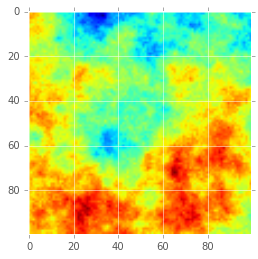

In [72]:
%%time 
vm = sptools.ExponentialVariogram(sill=0.3,range_a=0.4)
xx,yy,z = sptools.simulatedGaussianFieldAsPcolorMesh(vm,grid_sizex=100,grid_sizey=100,random_seed=1234)
plt.imshow(z)

# comparison

| Size     | Method        | Seconds   |
|----------|---------------|-----------|
| 100x100  | Full Gaussian | 346       | 
| 100x100  | Markov FFT    | 0.151     |


The stationary circulant markov FFT method is 2291x faster



In [75]:
346 / 0.151

2291.390728476821

In [77]:
c

array([[ 4.00001, -1.     ,  0.     , ...,  0.     ,  0.     , -1.     ],
       [-1.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       ...,
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [-1.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ]])

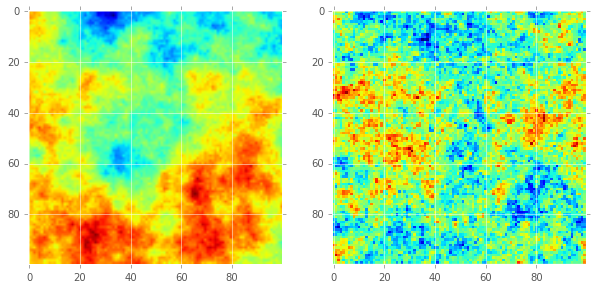

In [76]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(z)
plt.subplot(1,2,2)
plt.imshow(x,interpolation='None')